In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import montecarlo_localization as mcl
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Monte Carlo localization

This notebook presents a demonstration of Erik Sjoberg's implementation of Monte Carlo localization (particle filter) on a dataset of 2d laser scans

## Example laser scan data

Note the legs of a person walking beside the robot appear in the dataset. 

This dynamic obstacle will increase the difficulty of the localization.

<img  src="data/robotmovie1.gif"/>

## Corresponding relative odometry log data

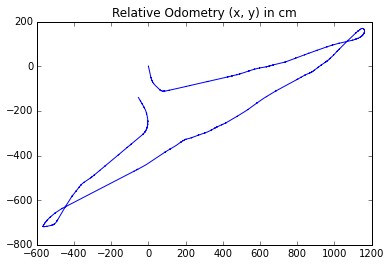

In [6]:
logdata = mcl.load_log('data/log/robotdata1.log.gz')
logdata['x_rel'] = logdata['x'] - logdata.ix[0,'x']
logdata['y_rel'] = logdata['y'] - logdata.ix[0,'y']
plt.plot(logdata['x_rel'], logdata['y_rel'])
plt.title('Relative Odometry (x, y) in cm')

Note the significant drift in the path according to the odometry data above, which should have returned to it's initial position

## Map to localize within

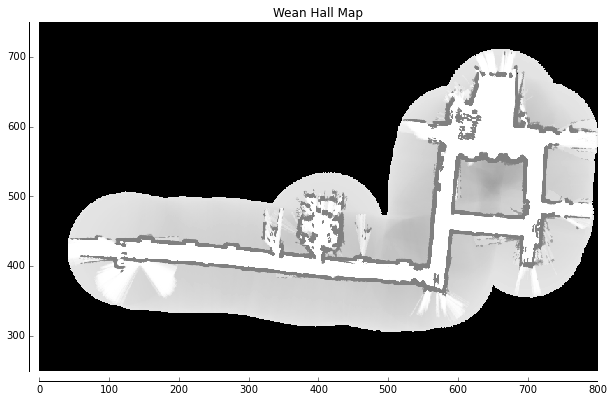

In [10]:
global_map = mcl.occupancy_map('data/map/wean.dat.gz')
mcl.draw_map_state(global_map, rotate=True)

# Localization Program Execution

In [6]:
# Map exists which all robot particles operate in
# Particles each have a motion model and a measurement model

# Need to sample:
#   Motion model for particle (given location of particle, map)
#           Motion model (in this case) comes from log + noise. 
#   Measurement model for particle (given location, map)
#           True measurements come from log

 
wean_hall_map = mcl.occupancy_map('data/map/wean.dat')
laser = mcl.laser_sensor()

#Initialize 100 particles uniformly in valid locations on the map
particle_list = [mcl.robot_particle(wean_hall_map, laser)
                 for _ in range(100)]

#Load in log data with absolute measurements in odometry frame
logdata = mcl.load_log('data/log/robotdata1.log.gz')
# each log msg: ['type','ts', 'x', 'y', 'theta', 'xl','yl', 'thetal', r1~r180]

# Main loop simulating time in the program
for msg in logdata.values:
    particle_list = mcl.mcl_update(particle_list, msg) # Update
    mcl.draw_map_state(wean_hall_map, particle_list)




NameError: name 'new_particle_weight' is not defined

### View log data

In [7]:
logdata = mcl.load_log('data/log/robotdata1.log.gz')
logdata['x_rel'] = logdata['x'] - logdata.ix[0,'x']
logdata['y_rel'] = logdata['y'] - logdata.ix[0,'y']
plt.plot(logdata['x_rel'], logdata['y_rel'])

In [8]:

logdata['theta_rel'] = logdata['theta'] - logdata.ix[0,'theta']
logdata['xl_rel'] = logdata['xl'] - logdata.ix[0,'xl']
logdata['yl_rel'] = logdata['yl'] - logdata.ix[0,'yl']
logdata['thetal_rel'] = logdata['thetal'] - logdata.ix[0,'thetal']

In [9]:
logdata['dt'] = logdata['ts'].shift(-1) - logdata['ts']
logdata['dx'] = logdata['x'].shift(-1) - logdata['x']
logdata['dy'] = logdata['y'].shift(-1) - logdata['y']
logdata['dtheta'] = logdata['theta'].shift(-1) - logdata['theta']
logdata['dxl'] = logdata['xl'].shift(-1) - logdata['xl']
logdata['dyl'] = logdata['yl'].shift(-1) - logdata['yl']
logdata['dthetal'] = logdata['thetal'].shift(-1) - logdata['thetal']

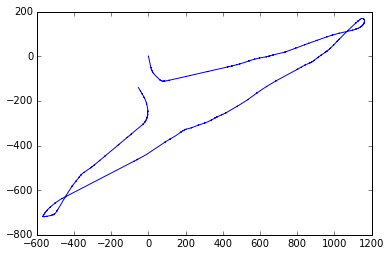